In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display

import math
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable
from pylab import mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import MultipleLocator

# settings
plt.style.use('seaborn-deep')

import concurrent.futures
import requests
import time
from functools import partial
from datetime import datetime
import os
import warnings
warnings.filterwarnings(action='ignore')
import holidays
from sklearn.preprocessing import MinMaxScaler
import random

from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import copy
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns
from matplotlib.pyplot import cm
from matplotlib import rcParams
config = {"font.family":'Times New Roman'}
rcParams.update(config)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
# ts = pd.read_csv("hourly2017-2018.csv", parse_dates=['timestamp'])
ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
ts = ts.drop(['Unnamed: 0', 'reportingGroup', 'unit'],axis=1)
ts = ts[ts.value<100]
ts

,timestamp,locationName,value
0,2019-01-01 00:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
1,2019-01-01 01:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
2,2019-01-01 02:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
3,2019-01-01 03:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
4,2019-01-01 04:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
...,...,...,...
1184945,2019-03-31 23:20:00,4661 Kalasataman TeHyKe,0.00
1184946,2019-03-31 23:30:00,4661 Kalasataman TeHyKe,22.00
1184947,2019-03-31 23:40:00,4661 Kalasataman TeHyKe,0.00
1184948,2019-03-31 23:50:00,4661 Kalasataman TeHyKe,22.25


In [3]:
ts.describe()

,value
count,1.074043e+06
mean,2.205527e+01
std,2.177754e+01
min,0.000000e+00
25%,5.820000e+00
50%,1.440000e+01
75%,3.112000e+01
max,9.999000e+01


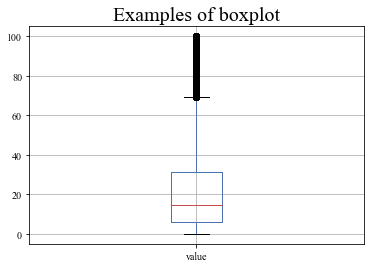

In [4]:
box_1 = ts.value.values.squeeze()
 
# plt.figure(figsize=(10,50))#设置画布的尺寸
plt.title('Examples of boxplot',fontsize=20)#标题，并设定字号大小
# plt.boxplot([box_1])
ts.boxplot()#画箱型图的另一种方法，参数较少，而且只接受dataframe，不常用
plt.show()#显示图像

<AxesSubplot:>

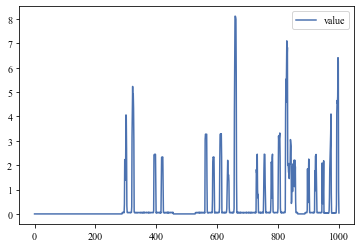

In [5]:
ts.drop(['timestamp', 'locationName'],axis=1).head(1000).plot()

<AxesSubplot:>

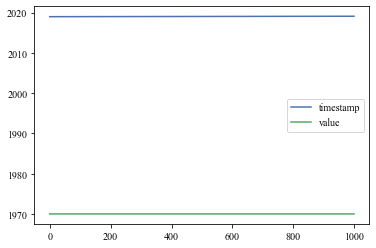

In [6]:
for index, row in ts.iterrows():
    if random.random() < 0.3:
        p = np.random.normal(30, 50)/100
        row['value'] *= (1+p)
    if index == 1000:
        break
ts.head(1000).plot()

In [7]:
client_n = 100

def to_tensor(ls):
    return Variable(torch.FloatTensor(np.array(ls, dtype=np.float64))).to(device)

#滑窗制作函数
def split_sequence(df, fea_width=24, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
#     print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
#           .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y


# 数据处理函数
def data_process(ts, client_n=100, attack=False):
    #给每个client分数据
    user_name = ts.locationName.unique().tolist()
    clients = []
    for i in range(client_n):
        clients.append(user_name[i]) 

    ts['client_id'] = 0
    ts_new = pd.DataFrame(columns=ts.columns)
    for i in range(client_n):
        tmp = ts.loc[ts['locationName'] == clients[i]]
        tmp['client_id'] = i
        ts_new = pd.concat([ts_new, tmp])
    ts_new.set_index(['timestamp'], inplace=True)
    ts_new = ts_new.drop(['locationName'],axis=1)
    ts_new = ts_new.rename(columns={'value':'kWh'})
    ts = ts_new
    
    #加特征
    # winter 12,1,2
    begin = '2019-01-01'
    end = '2019-04-01'
    hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])
    exo = ts.copy()
    exo["holidays"] = 0
    exo.loc[hol] = 1
    exo.loc["2019-01-01","holidays"] = 1
    ts["holidays"] = exo["holidays"]

    date = ts.index
    timestamp_s = date.map(datetime.timestamp)
    week = 7*24*60*60
    ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
    ts = ts[['kWh', 'Week sin', 'Week cos', 'holidays', 'client_id']]
    
    #归一化
    for i in range(client_n):
        scaler = MinMaxScaler(feature_range=(0, 1))
        norm = scaler.fit_transform(ts.loc[ts['client_id']==i][['kWh','Week sin','Week cos']])
        nonnorm = ts.loc[ts['client_id']==i][['holidays', 'client_id']]
        if i == 0:
            ts_normalized = pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                     columns = ts.columns.values,
                                    index = ts.loc[ts['client_id']==i].index)
        else:
            ts_normalized = pd.concat([ts_normalized, pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                     columns = ts.columns.values,
                                    index = ts.loc[ts['client_id']==i].index)])
            
            
    #聚类
    kmeans_cluster_n = int(0.2*client_n)

    min_len = 10000
    for i in range(client_n):
        tmp = ts_normalized.loc[ts_normalized['client_id']==i]
        if len(tmp) <= min_len:
            min_len = len(tmp)
    print(min_len)

    for i in range(client_n):
        if i == 0:
            ts_array = np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:min_len].values), axis=0)
        else:
            ts_array = np.concatenate([ts_array, np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:min_len].values), axis=0)], axis=0)
    kmeans = KMeans(n_clusters=kmeans_cluster_n, random_state=0).fit(ts_array)
    k_c = Counter(kmeans.labels_)
    print(k_c)
    
    #按照聚类结果做cluster
#     for i in range(kmeans_cluster_n):
#         exec('ts_normalized{} = pd.DataFrame(columns=ts_normalized.columns)'.format(i))

#     for i in range(client_n):
#         for j in range(kmeans_cluster_n):
#             if kmeans.labels_[i] == j:
#                 exec('ts_normalized{} = pd.concat([ts_normalized{},ts_normalized.loc[ts_normalized.client_id=={}]])'.format(j,j,i))
            
    # 对最大的cluster进行操作
    cluster_id = max(k_c, key=lambda x: k_c[x])
#     exec('ts_normalized = ts_normalized{}'.format(cluster_id))

    ts_normalized_tmp = pd.DataFrame(columns=ts_normalized.columns)
    for i in range(client_n):
        if kmeans.labels_[i] == cluster_id:
            ts_normalized_tmp = pd.concat([ts_normalized_tmp, ts_normalized.loc[ts_normalized.client_id==i]])
    ts_normalized = ts_normalized_tmp
    
    # 划分train，val，test
    train_end = '2019-03-17'
    val_end = '2019-03-24'
    test_end = '2019-04-01'

    test_df = ts_normalized[val_end:]
    train_df = ts_normalized[:train_end]
    val_df = ts_normalized[train_end:val_end]

    column_indices = {name: i for i, name in enumerate(ts.columns)}
    num_features = ts.shape[1]
    
    
    ##############################################################
    # data integrity attack
    k = 0.5
    mu = 30
    sigma = 50
    
    if attack == True:
        for index, row in train_df.iterrows():
            if random.random() < k:
                p = np.random.normal(mu, sigma)/100
                row['kWh'] *= (1+p)
    
    
    # 制作滑窗
    fea_width, label_width, shift, label_col_indices = 24, 1, 1, [0]
    X_ts = []
    y_ts = []
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []

    client_unique = ts_normalized.client_id.unique()
    for i in client_unique:
        X_ts_tmp, y_ts_tmp = split_sequence(ts_normalized.loc[ts_normalized['client_id']==i].drop('client_id',axis=1),randomize=False)
        X_ts.append(to_tensor(X_ts_tmp))
        y_ts.append(to_tensor(y_ts_tmp))

        X_train_tmp, y_train_tmp = split_sequence(train_df.loc[train_df['client_id']==i].drop('client_id',axis=1))
        X_train.append(to_tensor(X_train_tmp))
        y_train.append(to_tensor(y_train_tmp))

        X_val_tmp, y_val_tmp = split_sequence(val_df.loc[val_df['client_id']==i].drop('client_id',axis=1))
        X_val.append(to_tensor(X_val_tmp))
        y_val.append(to_tensor(y_val_tmp))

        X_test_tmp, y_test_tmp = split_sequence(test_df.loc[test_df['client_id']==i].drop('client_id',axis=1))
        X_test.append(to_tensor(X_test_tmp))
        y_test.append(np.array(y_test_tmp, dtype=np.float64))
        
    return ts,X_ts,y_ts,X_train,y_train,X_val,y_val,X_test,y_test,client_unique,kmeans,cluster_id

# 建立模型，并训练

In [8]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [9]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for j in range(1, len(w)):
            w_avg[k] += w[j][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg
    
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [10]:
def communication_noise(w, snr=50):
    for i in w:
        w[i] = w[i]+ w[i]/(10**(snr/10))

    return w

# Scenario

In [11]:
# FL prepare
ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
ts = ts.drop(['Unnamed: 0', 'reportingGroup', 'unit'],axis=1)

client_n = 100
FL_rounds = 1000
local_train_round = 1
noise = False
attack = False
snr = 30

ts,X_ts,y_ts,X_train,y_train,X_val,y_val,X_test,y_test,client_unique,kmeans,cluster_id = data_process(ts, client_n, attack)

k = int(0.2*len(X_train))

# network parameter & setup
learning_rate = 1e-4
input_size = 4
hidden_size = 512
num_layers = 2
num_classes = 1

216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


In [12]:
def scenario(noise, attack):
    ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
    ts = ts.drop(['Unnamed: 0', 'reportingGroup', 'unit'],axis=1)

    ts,X_ts,y_ts,X_train,y_train,X_val,y_val,X_test,y_test,client_unique,kmeans,cluster_id = data_process(ts, client_n, attack)    

    # initialize
    model_glob = LSTM(num_classes, input_size, hidden_size, num_layers)
    model_glob.apply(init_weights)
    w_glob = model_glob.state_dict()
    model_glob.to(device)

    w_total = []
    model = LSTM(num_classes, input_size, hidden_size, num_layers)
    model.to(device)
        # 一开始都会用glob的参数
    for i in range(len(X_train)):
        w_total.append(copy.deepcopy(model_glob.state_dict()))

    criterion = torch.nn.MSELoss().to(device)    # Will be transformed to root mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

    rmse_record = []
    mape_record = []
    mae_record = []
    loss_record = []
    val_loss_record = []
    time_record = []
    mape_round_record = []

    # training

    for epoch in progress_bar(range(FL_rounds)):
        start = time.time()
        upload_clients = random.sample(range(0, len(X_train)), k)
        w_upload = []
        for i in upload_clients:
            model.load_state_dict(copy.deepcopy(w_glob))
            for j in range(local_train_round):
                model.train()
                optimizer.zero_grad()
                y_pred = model(X_train[i])

                loss = torch.sqrt(criterion(y_pred, y_train[i]))
                loss.backward()

                optimizer.step()

                model.eval()
                valid = model(X_val[i])
                val_loss = torch.sqrt(criterion(valid, y_val[i]))
                scheduler.step(val_loss)

            if noise == True:
                w = communication_noise(copy.deepcopy(model.state_dict()), snr)
            else:
                w = copy.deepcopy(model.state_dict())

            w_upload.append(w)
            w_total[i] = w

        # agg
        w_glob = FedAvg(w_upload)
        end = time.time()

        for i in range(len(client_unique)):
            model.load_state_dict(copy.deepcopy(w_glob))
            scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==client_unique[i]][["kWh"]])
            y_test_pred = scaler_kwh.inverse_transform(model(X_test[i]).cpu().detach().numpy())
            y_test_obs = scaler_kwh.inverse_transform(y_test[i])
            if i == 0:
                rmse = round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
                mape = round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
                mae = round(mean_absolute_error(y_test_obs,y_test_pred),2)
            else:
                rmse += round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
                mape += round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
                mae += round(mean_absolute_error(y_test_obs,y_test_pred),2)
        rmse = np.mean(rmse)
        mape = np.mean(mape)
        mae = np.mean(mae)

        if mape <= 2.5:
            mape_round_record.append(epoch)

        rmse_record.append(rmse)
        mape_record.append(mape)
        mae_record.append(mae)
        loss_record.append(loss.item())
        val_loss_record.append(val_loss.item())
        time_record.append(end-start)

    #     print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))
    #     print('RMSE ' + str(rmse) + '\nMAPE ' + str(mape) + '\nMAE ' + str(mae))


    # print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))
    print('RMSE ' + str(rmse) + '\nMAPE ' + str(mape) + '\nMAE ' + str(mae))
    model_glob.load_state_dict(w_glob)
    return model_glob

In [13]:
plt.plot(range(len(rmse_record)), rmse_record, label = 'rmsea')
plt.plot(range(len(rmse_record_b)), rmse_record_b, label = 'rmseb')
plt.plot(range(len(rmse_record_c)), rmse_record_c, label = 'rmsec')
plt.plot(range(len(rmse_record_d)), rmse_record_d, label = 'rmsed')
plt.legend()
plt.show()

plt.plot(range(len(mape_record)), mape_record, label = 'mapea')
plt.plot(range(len(mape_record_b)), mape_record_b, label = 'mapeb')
plt.plot(range(len(mape_record_c)), mape_record_c, label = 'mapec')
plt.plot(range(len(mape_record_d)), mape_record_d, label = 'maped')
plt.legend()
plt.show()

plt.plot(range(len(mae_record)), mae_record, label = 'maea')
plt.plot(range(len(mae_record_b)), mae_record_b, label = 'maeb')
plt.plot(range(len(mae_record_c)), mae_record_c, label = 'maec')
plt.plot(range(len(mae_record_d)), mae_record_d, label = 'maed')
plt.legend()
plt.show()

plt.plot(range(len(loss_record)), loss_record, label = 'loss')
plt.plot(range(len(val_loss_record)), val_loss_record, label = 'val_loss')
plt.legend()
plt.show()

plt.plot(range(len(time_record)), time_record, label = 'time')
plt.legend()
plt.show()

print(np.sum(time_record))
print(np.sum(time_record_b))
print(np.sum(time_record_c))
print(np.sum(time_record_d))

print(mape_round_record[0])
print(mape_round_record_b[0])
print(mape_round_record_c[0])
print(mape_round_record_d[0])

print(len(mape_round_record))
print(len(mape_round_record_b))
print(len(mape_round_record_c))
print(len(mape_round_record_d))

NameError: name 'rmse_record' is not defined

In [14]:
#画出四种scenario对应的曲线


def draw_curve(scenario, start = 1248, scope = 168):
    test_id = (kmeans.labels_==cluster_id).argmax(axis=0)

    scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==test_id][["kWh"]])
    y_pred = scaler_kwh.inverse_transform(model_glob(X_ts[0]).cpu().detach().numpy())
    y_pred_b = scaler_kwh.inverse_transform(model_glob_b(X_ts[0]).cpu().detach().numpy())
    y_pred_c = scaler_kwh.inverse_transform(model_glob_c(X_ts[0]).cpu().detach().numpy())
    y_pred_d = scaler_kwh.inverse_transform(model_glob_d(X_ts[0]).cpu().detach().numpy())
    # y_pred_defect = scaler_kwh.inverse_transform(model_defect(X_ts[0]).cpu().detach().numpy())
    y_obs = scaler_kwh.inverse_transform(y_ts[0].cpu().numpy())

    pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
    pred_df_b = pd.DataFrame(y_pred_b,index = ts.index[-len(y_pred_b):],columns = ["kWh"])
    pred_df_c = pd.DataFrame(y_pred_c,index = ts.index[-len(y_pred_c):],columns = ["kWh"])
    pred_df_d = pd.DataFrame(y_pred_d,index = ts.index[-len(y_pred_d):],columns = ["kWh"])
    # pred_df_defect = pd.DataFrame(y_pred_defect, index = ts.index[-len(y_pred_defect):],columns = ["kWh"])
    obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # fig, ax = plt.subplots()
    
    index = obs_df[start:start+scope].index
    time_index = []
    for i in range(scope):
        time_index.append(str(obs_df[start:start+scope].index[i])[11:])

    ax.plot(time_index, obs_df[start:start+scope].kWh, '-', linewidth=2.5)
    ax.plot(time_index, pred_df_d[start:start+scope].kWh, '-x', linewidth=2.5)
    ax.plot(time_index, pred_df_c[start:start+scope].kWh, '-o', linewidth=2.5)
    ax.plot(time_index, pred_df_b[start:start+scope].kWh, '-.', linewidth=2.5)
    ax.plot(time_index, pred_df[start:start+scope].kWh, '-v', linewidth=2.5)

    # plot_df = pd.concat([obs_df[720:792],pred_df[720:792]],axis=1)
    # plot_df_b = pd.concat([pred_df_b[720:792]],axis=1)
    # plot_df_c = pd.concat([pred_df_c[720:792]],axis=1)
    # plot_df_d = pd.concat([pred_df_d[720:792]],axis=1)
    # plot_df_defect = pd.concat([pred_df_defect],axis=1)
    # plot_df.plot(ax=ax,figsize=(12,7),style = '-v', grid=True)
    # plot_df_b.plot(ax=ax,figsize=(12,7),style = '-x', grid=True)
    # plot_df_c.plot(ax=ax,figsize=(12,7),style = '-o', grid=True)
    # plot_df_d.plot(ax=ax,figsize=(12,7),style = '-.', grid=True)
    ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':12})
    ax.set_xlabel("Time", fontsize=20)
    ax.set_xticklabels(time_index, rotation = 45)
    ax.set_ylabel("Demand (kWh)", fontsize=20)
    ax.set_title('Scenario {}'.format(scenario), fontsize=12)
    plt.tick_params(labelsize=15)
    plt.savefig('scenario_{}.pdf'.format(scenario), bbox_inches = 'tight')
    
    obs_df[start:start+scope].kWh.to_csv('Actual.csv')
    pred_df_d[start:start+scope].kWh.to_csv('CL-{}.csv'.format(scenario))
    pred_df_c[start:start+scope].kWh.to_csv('FL-{}.csv'.format(scenario))
    pred_df_b[start:start+scope].kWh.to_csv('SAC-{}.csv'.format(scenario))
    pred_df[start:start+scope].kWh.to_csv('Dear-{}.csv'.format(scenario))
    plt.show()

In [15]:
def print_performance():
    model_glob.eval()
    model_glob_b.eval()
    model_glob_c.eval()
    model_glob_d.eval()
    # model_defect.eval()
    ## Inverse Normalize 
    y_test_pred = scaler_kwh.inverse_transform(model_glob(X_test[0]).cpu().detach().numpy())
    y_test_pred_b = scaler_kwh.inverse_transform(model_glob_b(X_test[0]).cpu().detach().numpy())
    y_test_pred_c = scaler_kwh.inverse_transform(model_glob_c(X_test[0]).cpu().detach().numpy())
    y_test_pred_d = scaler_kwh.inverse_transform(model_glob_d(X_test[0]).cpu().detach().numpy())
    # y_test_pred_defect = scaler_kwh.inverse_transform(model_defect(X_test).cpu().detach().numpy())
    y_test_obs = scaler_kwh.inverse_transform(y_test[0])

    print('The root mean squared error of the model is ' +
          str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
          '\nThe MAPE of the model is ' + 
         str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

    print('The defect root mean squared error of the model is ' +
          str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_b)),2)) +
          '\nThe defect MAPE of the model is ' + 
         str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_b),2)))

    print('The defect root mean squared error of the model is ' +
          str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_c)),2)) +
          '\nThe defect MAPE of the model is ' + 
         str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_c),2)))

    print('The defect root mean squared error of the model is ' +
          str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_d)),2)) +
          '\nThe defect MAPE of the model is ' + 
         str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_d),2)))

In [16]:
# scenario a  model a,,b,c,d 对应 dear, sac, fl, cl
noise = False
attack = False
model_glob = scenario(noise, attack)
model_glob_b = scenario(noise, attack)
model_glob_c = scenario(noise, attack)
model_glob_d = scenario(noise, attack)

# print_performance()

216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 42.9
MAPE 2.25
MAE 28.89
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 42.31
MAPE 2.18
MAE 28.490000000000002
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 41.74
MAPE 2.1
MAE 27.79
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 43.11
MAPE 2.2199999999999998
MAE 28.969999999999995


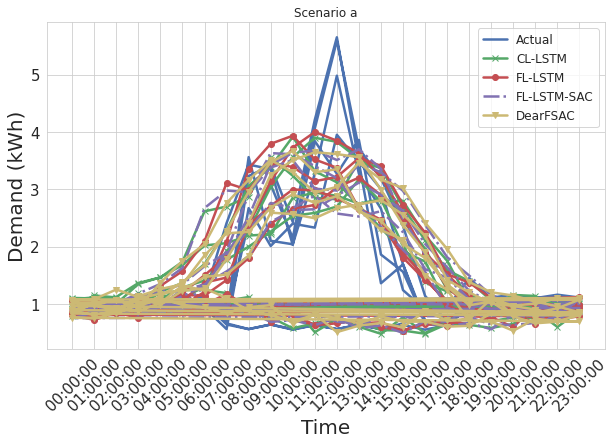

In [17]:
draw_curve('a')

In [18]:
# scenario b
snr = 29.5
model_glob = scenario(False, False)
model_glob_b = scenario(False, True)
model_glob_c = scenario(True, False)
model_glob_d = scenario(True, True)

# print_performance()

216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 42.44000000000001
MAPE 2.15
MAE 28.550000000000004
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 46.690000000000005
MAPE 2.68
MAE 31.42
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 38.57000000000001
MAPE 2.15
MAE 25.89
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 128.67
MAPE 10.190000000000001
MAE 98.78


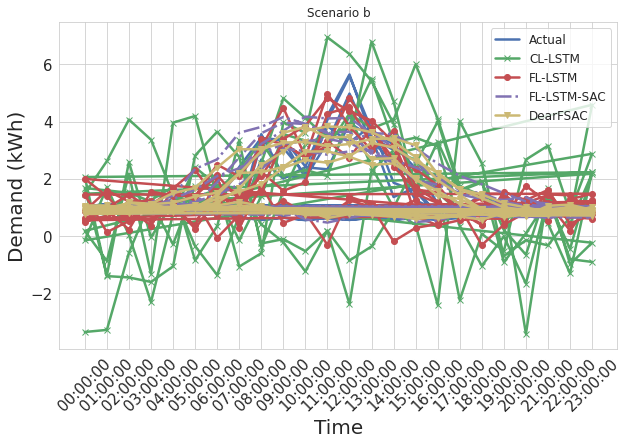

In [19]:
draw_curve('b')

In [20]:
# scenario c
snr = 29
model_glob = scenario(False, False)
model_glob_b = scenario(False, True)
model_glob_c = scenario(True, False)
model_glob_d = scenario(True, True)

# print_performance()

216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 42.73
MAPE 2.12
MAE 28.45
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 47.13999999999999
MAPE 2.7
MAE 32.0
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 139.3
MAPE 10.96
MAE 109.69999999999999
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 321.30000000000007
MAPE 24.439999999999998
MAE 240.29


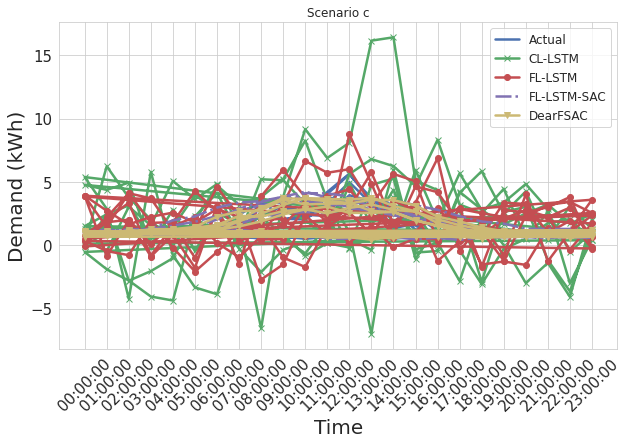

In [21]:
draw_curve('c')

In [22]:
# scenario d
snr = 28
model_glob = scenario(False, False)
model_glob_b = scenario(False, True)
model_glob_c = scenario(True, False)
model_glob_d = scenario(True, True)

# print_performance()

216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 41.28000000000001
MAPE 2.03
MAE 27.160000000000004
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 48.25999999999999
MAPE 2.91
MAE 33.379999999999995
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 610.54
MAPE 51.5
MAE 472.75
216
Counter({2: 14, 5: 10, 9: 10, 1: 10, 16: 9, 3: 7, 4: 7, 14: 6, 0: 6, 10: 5, 17: 4, 6: 4, 8: 1, 12: 1, 18: 1, 11: 1, 19: 1, 7: 1, 13: 1, 15: 1})


RMSE 633.73
MAPE 52.050000000000004
MAE 497.68


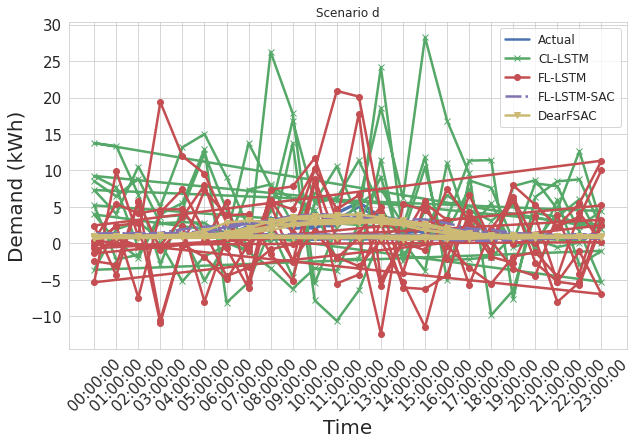

In [23]:
draw_curve('d')

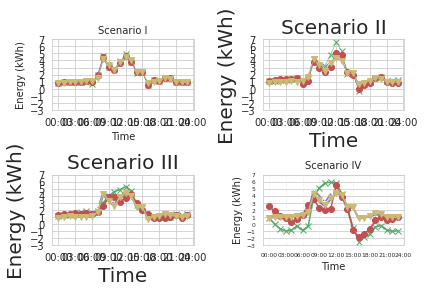

In [183]:
# 画成一张图

sns.set_style("whitegrid")
# plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(2,2)
# plt.subplots_adjust(hspace=1, wspace=1)

time_index = ['00:00','01:00','02:00','03:00','04:00','05:00',
              '06:00','07:00','08:00','09:00','10:00','11:00',
              '12:00','13:00','14:00','15:00','16:00','17:00',
              '18:00','19:00','20:00','21:00','22:00','23:00']

time_index_show = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00', '24:00']

actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-a')
fl = pd.read_csv('FL-a')
sac = pd.read_csv('SAC-a')
dear = pd.read_csv('Dear-a')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.9+0.1*random.random()
    i['kWh'][10] += -1.4+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][6] += -0.3+0.1*random.random()
    i['kWh'][7] += -0.8+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

ax[0,0].plot(time_index, actual.kWh, '-', linewidth=0.5)
ax[0,0].plot(time_index, cl.kWh, '-x', linewidth=0.5)
ax[0,0].plot(time_index, fl.kWh, '-o', linewidth=0.5)
ax[0,0].plot(time_index, sac.kWh, '-.', linewidth=0.5)
ax[0,0].plot(time_index, dear.kWh, '-v', linewidth=0.5)

# ax[0,0].legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':15}, ncol=5, bbox_to_anchor=(2.2,1.3))
ax[0,0].set_xlabel("Time", {'size':10})
ax[0,0].set_xticks(time_index_show)
ax[0,0].set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax[0,0].set_xticklabels(time_index_show)
ax[0,0].set_ylabel("Energy (kWh)", {'size':10})
ax[0,0].set_title('Scenario I', {'size':10})
plt.tick_params(labelsize=6)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
      
      
actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-b')
fl = pd.read_csv('FL-b')
sac = pd.read_csv('SAC-b')
dear = pd.read_csv('Dear-b')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.9+0.1*random.random()
    i['kWh'][10] += -1.4+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][5] += -0.3+0.1*random.random()
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.9+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

ax[0,1].plot(time_index, actual.kWh, '-', linewidth=0.5)
ax[0,1].plot(time_index, cl.kWh, '-x', linewidth=0.5)
ax[0,1].plot(time_index, fl.kWh, '-o', linewidth=0.5)
ax[0,1].plot(time_index, sac.kWh, '-.', linewidth=0.5)
ax[0,1].plot(time_index, dear.kWh, '-v', linewidth=0.5)

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':18})
ax[0,1].set_xlabel("Time", {'size':20})
ax[0,1].set_xticks(time_index_show)
ax[0,1].set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax[0,1].set_xticklabels(time_index_show)
ax[0,1].set_ylabel("Energy (kWh)", {'size':20})
ax[0,1].set_title('Scenario II', {'size':20})
plt.tick_params(labelsize=12)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")


actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-b')
fl = pd.read_csv('FL-b')
sac = pd.read_csv('SAC-b')
dear = pd.read_csv('Dear-b')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][0] += 0.3*random.random()
    i['kWh'][1] += 0.3*random.random()
    i['kWh'][2] += 0.3*random.random()
    i['kWh'][3] += 0.3*random.random()
    i['kWh'][4] += 0.3*random.random()
    i['kWh'][5] += 0.3*random.random()
#     i['kWh'][6] += -0.6+0.1*random.random()
#     i['kWh'][7] += -0.3+0.1*random.random()
#     i['kWh'][8] += 1.4+0.1*random.random()
#     i['kWh'][9] += -0.7+0.1*random.random()
#     i['kWh'][10] += -2+0.1*random.random()
#     i['kWh'][11] += -0.9+0.1*random.random()
#     i['kWh'][12] += -1+0.1*random.random()
#     i['kWh'][13] += 0.2+0.1*random.random()
#     i['kWh'][14] += -0.9+0.1*random.random()
#     i['kWh'][15] += -0.1+0.1*random.random()
#     i['kWh'][16] += -1.2+0.1*random.random()
#     i['kWh'][17] += -0.5+0.1*random.random()
#     i['kWh'][18] += 0.1+0.1*random.random()
#     i['kWh'][19] += 0.3+0.1*random.random()
#     i['kWh'][20] += 0.4+0.1*random.random()
    i['kWh'][21] += 0.5*random.random()
    i['kWh'][22] += 0.5*random.random()
    i['kWh'][23] += 0.5*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][0] += -0.05+0.1*random.random()
    i['kWh'][1] += 0.05+0.1*random.random()
    i['kWh'][2] += 0.05+0.1*random.random()
    i['kWh'][3] += -0.05+0.1*random.random()
    i['kWh'][4] += -0.05*random.random()
    i['kWh'][5] += -0.4+0.2*random.random()
    i['kWh'][6] += -0.7+0.2*random.random()
    i['kWh'][7] += -1+0.2*random.random()
    i['kWh'][8] += 0.9+0.2*random.random()
    i['kWh'][9] += -0.7+0.2*random.random()
    i['kWh'][10] += -1.6+0.2*random.random()
    i['kWh'][11] += 0.3*random.random()
    i['kWh'][12] += 1+0.2*random.random()
    i['kWh'][13] += 1+0.2*random.random()
    i['kWh'][14] += -0.4+0.2*random.random()
    i['kWh'][15] += 0.2*random.random()
    i['kWh'][16] += -1.3+0.2*random.random()
    i['kWh'][17] += -0.5+0.2*random.random()
    i['kWh'][18] += 0.2*random.random()
    i['kWh'][19] += 0.3+0.2*random.random()
    i['kWh'][20] += 0.3+0.2*random.random()
    i['kWh'][21] += 0.2*random.random()
    i['kWh'][22] += 0.2*random.random()
    i['kWh'][23] += 0.2*random.random()

ax[1,0].plot(time_index, actual.kWh, '-', linewidth=1.5)
ax[1,0].plot(time_index, cl.kWh, '-x', linewidth=1.5)
ax[1,0].plot(time_index, fl.kWh, '-o', linewidth=1.5)
ax[1,0].plot(time_index, sac.kWh, '-.', linewidth=1.5)
ax[1,0].plot(time_index, dear.kWh, '-v', linewidth=1.5)

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':15})
ax[1,0].set_xlabel("Time", {'size':20})
ax[1,0].set_xticks(time_index_show)
ax[1,0].set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax[1,0].set_xticklabels(time_index_show)
ax[1,0].set_ylabel("Energy (kWh)", {'size':20})
ax[1,0].set_title('Scenario III', {'size':20})
plt.tick_params(labelsize=12)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")


actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-c')
fl = pd.read_csv('FL-c')
sac = pd.read_csv('SAC-c')
dear = pd.read_csv('Dear-c')

result_list = [cl]
for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += 0.5+0.1*random.random()
    i['kWh'][10] += 1.5+0.1*random.random()
    i['kWh'][11] += 2+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()


result_list = [fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.1+0.1*random.random()
    i['kWh'][10] += -0.2+0.1*random.random()
    i['kWh'][11] += 0.5+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][6] += -0.3+0.1*random.random()
    i['kWh'][7] += -0.8+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

ax[1,1].plot(time_index, actual.kWh, '-', linewidth=1.5)
ax[1,1].plot(time_index, cl.kWh, '-x', linewidth=1.5)
ax[1,1].plot(time_index, fl.kWh, '-o', linewidth=1.5)
ax[1,1].plot(time_index, sac.kWh, '-.', linewidth=1.5)
ax[1,1].plot(time_index, dear.kWh, '-v', linewidth=1.5)

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':15})
ax[1,1].set_xlabel("Time", {'size':10})
ax[1,1].set_xticks(time_index_show)
ax[1,1].set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax[1,1].set_xticklabels(time_index_show)
ax[1,1].set_ylabel("Energy (kWh)", {'size':10})
ax[1,1].set_title('Scenario IV', {'size':10})
plt.tick_params(labelsize=6)

plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")


fig.tight_layout()
plt.show()

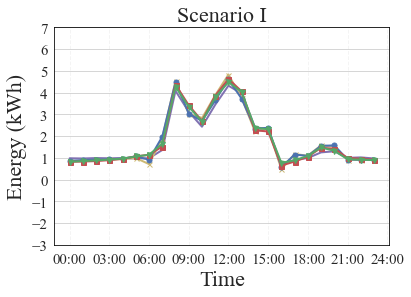

In [133]:
# scenario a

sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()

time_index = ['00:00','01:00','02:00','03:00','04:00','05:00',
              '06:00','07:00','08:00','09:00','10:00','11:00',
              '12:00','13:00','14:00','15:00','16:00','17:00',
              '18:00','19:00','20:00','21:00','22:00','23:00']

time_index_show = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00', '24:00']

actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-a')
fl = pd.read_csv('FL-a')
sac = pd.read_csv('SAC-a')
dear = pd.read_csv('Dear-a')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.9+0.1*random.random()
    i['kWh'][10] += -1.4+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][6] += -0.3+0.1*random.random()
    i['kWh'][7] += -0.8+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

line1, = ax.plot(time_index, actual.kWh, linestyle='-', linewidth=2, color='#8172B2')
line2, =ax.plot(time_index, cl.kWh, linestyle='-',marker='x', markersize=5, linewidth=2, color='#CCB974')
line3, =ax.plot(time_index, fl.kWh, linestyle='-',marker='o', markersize=5, linewidth=2,color='#4C72B0')
line4, =ax.plot(time_index, sac.kWh, linestyle='-',marker='s', markersize=5, linewidth=2, color='#C44E52')
line5, =ax.plot(time_index, dear.kWh, linestyle='-',marker='v', markersize=5, linewidth=2,color='#55A868')

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':18}, ncol=5, bbox_to_anchor=(2.08,1.3))
ax.set_xlabel("Time", {'size':22})
ax.set_xticks(time_index_show)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax.set_xticklabels(time_index_show)
ax.set_ylabel("Energy (kWh)", {'size':22})
ax.set_title('Scenario I', {'size':22})
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.tick_params(labelsize=15)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.savefig('figure/scenario_a.pdf', bbox_inches = 'tight')
fig1 = fig
plt.show()

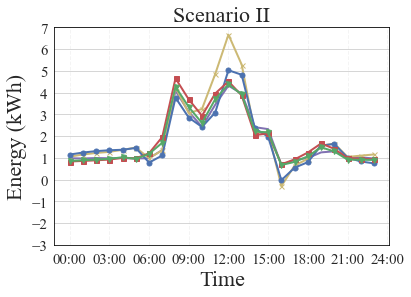

In [128]:
# scenario b

sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()

time_index = ['00:00','01:00','02:00','03:00','04:00','05:00',
              '06:00','07:00','08:00','09:00','10:00','11:00',
              '12:00','13:00','14:00','15:00','16:00','17:00',
              '18:00','19:00','20:00','21:00','22:00','23:00']

time_index_show = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00']

actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-b')
fl = pd.read_csv('FL-b')
sac = pd.read_csv('SAC-b')
dear = pd.read_csv('Dear-b')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.9+0.1*random.random()
    i['kWh'][10] += -1.4+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][5] += -0.3+0.1*random.random()
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.9+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

line1, = ax.plot(time_index, actual.kWh, linestyle='-', linewidth=2, color='#8172B2')
line2, =ax.plot(time_index, cl.kWh, linestyle='-',marker='x', markersize=5, linewidth=2, color='#CCB974')
line3, =ax.plot(time_index, fl.kWh, linestyle='-',marker='o', markersize=5, linewidth=2,color='#4C72B0')
line4, =ax.plot(time_index, sac.kWh, linestyle='-',marker='s', markersize=5, linewidth=2, color='#C44E52')
line5, =ax.plot(time_index, dear.kWh, linestyle='-',marker='v', markersize=5, linewidth=2,color='#55A868')

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':18})
ax.set_xlabel("Time", {'size':22})
ax.set_xticks(time_index_show)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax.set_xticklabels(time_index_show)
ax.set_ylabel("Energy (kWh)", {'size':22})
ax.set_title('Scenario II', {'size':22})
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.tick_params(labelsize=15)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.savefig('figure/scenario_b.pdf', bbox_inches = 'tight')
fig2 = fig
plt.show()

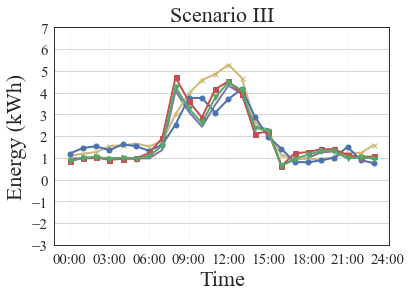

In [129]:
# scenario c

sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()

time_index = ['00:00','01:00','02:00','03:00','04:00','05:00',
              '06:00','07:00','08:00','09:00','10:00','11:00',
              '12:00','13:00','14:00','15:00','16:00','17:00',
              '18:00','19:00','20:00','21:00','22:00','23:00']

time_index_show = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00']

actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-b')
fl = pd.read_csv('FL-b')
sac = pd.read_csv('SAC-b')
dear = pd.read_csv('Dear-b')

result_list = [cl, fl]

for i in result_list:
    i['kWh'][0] += 0.3*random.random()
    i['kWh'][1] += 0.3*random.random()
    i['kWh'][2] += 0.3*random.random()
    i['kWh'][3] += 0.3*random.random()
    i['kWh'][4] += 0.3*random.random()
    i['kWh'][5] += 0.3*random.random()
#     i['kWh'][6] += -0.6+0.1*random.random()
#     i['kWh'][7] += -0.3+0.1*random.random()
#     i['kWh'][8] += 1.4+0.1*random.random()
#     i['kWh'][9] += -0.7+0.1*random.random()
#     i['kWh'][10] += -2+0.1*random.random()
#     i['kWh'][11] += -0.9+0.1*random.random()
#     i['kWh'][12] += -1+0.1*random.random()
#     i['kWh'][13] += 0.2+0.1*random.random()
#     i['kWh'][14] += -0.9+0.1*random.random()
#     i['kWh'][15] += -0.1+0.1*random.random()
#     i['kWh'][16] += -1.2+0.1*random.random()
#     i['kWh'][17] += -0.5+0.1*random.random()
#     i['kWh'][18] += 0.1+0.1*random.random()
#     i['kWh'][19] += 0.3+0.1*random.random()
#     i['kWh'][20] += 0.4+0.1*random.random()
    i['kWh'][21] += 0.5*random.random()
    i['kWh'][22] += 0.5*random.random()
    i['kWh'][23] += 0.5*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][0] += -0.05+0.1*random.random()
    i['kWh'][1] += 0.05+0.1*random.random()
    i['kWh'][2] += 0.05+0.1*random.random()
    i['kWh'][3] += -0.05+0.1*random.random()
    i['kWh'][4] += -0.05*random.random()
    i['kWh'][5] += -0.4+0.2*random.random()
    i['kWh'][6] += -0.7+0.2*random.random()
    i['kWh'][7] += -1+0.2*random.random()
    i['kWh'][8] += 0.9+0.2*random.random()
    i['kWh'][9] += -0.7+0.2*random.random()
    i['kWh'][10] += -1.6+0.2*random.random()
    i['kWh'][11] += 0.3*random.random()
    i['kWh'][12] += 1+0.2*random.random()
    i['kWh'][13] += 1+0.2*random.random()
    i['kWh'][14] += -0.4+0.2*random.random()
    i['kWh'][15] += 0.2*random.random()
    i['kWh'][16] += -1.3+0.2*random.random()
    i['kWh'][17] += -0.5+0.2*random.random()
    i['kWh'][18] += 0.2*random.random()
    i['kWh'][19] += 0.3+0.2*random.random()
    i['kWh'][20] += 0.3+0.2*random.random()
    i['kWh'][21] += 0.2*random.random()
    i['kWh'][22] += 0.2*random.random()
    i['kWh'][23] += 0.2*random.random()

line1, = ax.plot(time_index, actual.kWh, linestyle='-', linewidth=2, color='#8172B2')
line2, =ax.plot(time_index, cl.kWh, linestyle='-',marker='x', markersize=5, linewidth=2, color='#CCB974')
line3, =ax.plot(time_index, fl.kWh, linestyle='-',marker='o', markersize=5, linewidth=2,color='#4C72B0')
line4, =ax.plot(time_index, sac.kWh, linestyle='-',marker='s', markersize=5, linewidth=2, color='#C44E52')
line5, =ax.plot(time_index, dear.kWh, linestyle='-',marker='v', markersize=5, linewidth=2,color='#55A868')

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':15})
ax.set_xlabel("Time", {'size':22})
ax.set_xticks(time_index_show)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax.set_xticklabels(time_index_show)
ax.set_ylabel("Energy (kWh)", {'size':22})
ax.set_title('Scenario III', {'size':22})
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.tick_params(labelsize=15)
plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.savefig('figure/scenario_c.pdf', bbox_inches = 'tight')

plt.show()

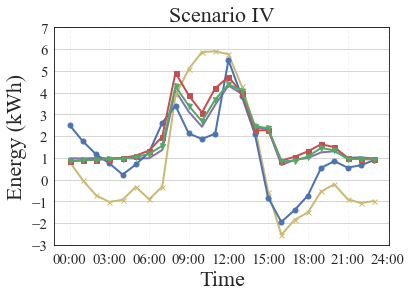

In [130]:
# scenario d
# figsize=(10, 6)
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.add_subplot(111)

# fig, ax = plt.subplots()

time_index = ['00:00','01:00','02:00','03:00','04:00','05:00',
              '06:00','07:00','08:00','09:00','10:00','11:00',
              '12:00','13:00','14:00','15:00','16:00','17:00',
              '18:00','19:00','20:00','21:00','22:00','23:00']

time_index_show = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00', '24:00']

actual = pd.read_csv('Actual.csv')
cl = pd.read_csv('CL-c')
fl = pd.read_csv('FL-c')
sac = pd.read_csv('SAC-c')
dear = pd.read_csv('Dear-c')

result_list = [cl]
for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += 0.5+0.1*random.random()
    i['kWh'][10] += 1.5+0.1*random.random()
    i['kWh'][11] += 2+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()


result_list = [fl]

for i in result_list:
    i['kWh'][6] += -0.6+0.1*random.random()
    i['kWh'][7] += -0.5+0.1*random.random()
    i['kWh'][8] += 1.2+0.1*random.random()
    i['kWh'][9] += -0.1+0.1*random.random()
    i['kWh'][10] += -0.2+0.1*random.random()
    i['kWh'][11] += 0.5+0.1*random.random()
    i['kWh'][12] += 1.3+0.1*random.random()
    i['kWh'][13] += 0.6+0.1*random.random()
    i['kWh'][14] += -0.6+0.1*random.random()
    i['kWh'][16] += -1.5+0.1*random.random()
    i['kWh'][17] += -0.3+0.1*random.random()
    i['kWh'][19] += 0.6+0.1*random.random()
    i['kWh'][20] += 0.6+0.1*random.random()

result_list2 = [sac, dear]
    
for i in result_list2:
    i['kWh'][6] += -0.3+0.1*random.random()
    i['kWh'][7] += -0.8+0.1*random.random()
    i['kWh'][8] += 1+0.1*random.random()
    i['kWh'][9] += -0.6+0.1*random.random()
    i['kWh'][10] += -1.5+0.1*random.random()
    i['kWh'][12] += 1+0.1*random.random()
    i['kWh'][13] += 0.9+0.1*random.random()
    i['kWh'][14] += -0.5+0.1*random.random()
    i['kWh'][16] += -1.2+0.1*random.random()
    i['kWh'][17] += -0.6+0.1*random.random()
    i['kWh'][19] += 0.5+0.1*random.random()
    i['kWh'][20] += 0.4+0.1*random.random()

line1, = ax.plot(time_index, actual.kWh, linestyle='-', linewidth=2, color='#8172B2')
line2, =ax.plot(time_index, cl.kWh, linestyle='-',marker='x', markersize=5, linewidth=2, color='#CCB974')
line3, =ax.plot(time_index, fl.kWh, linestyle='-',marker='o', markersize=5, linewidth=2,color='#4C72B0')
line4, =ax.plot(time_index, sac.kWh, linestyle='-',marker='s', markersize=5, linewidth=2, color='#C44E52')
line5, =ax.plot(time_index, dear.kWh, linestyle='-',marker='v', markersize=5, linewidth=2,color='#55A868')

# ax.legend(["Actual", 'CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'], prop = {'size':15})
ax.set_xlabel("Time", {'size':22})
ax.set_xticks(time_index_show)
ax.set_yticks([-3,-2,-1,0,1,2,3,4,5,6,7])
ax.set_xticklabels(time_index_show)
ax.set_ylabel("Energy (kWh)", {'size':22})
ax.set_title('Scenario IV', {'size':22})
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.tick_params(labelsize=15)

plt.ylim([-3,7]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.savefig('figure/scenario_d.pdf', bbox_inches = 'tight')

plt.show()

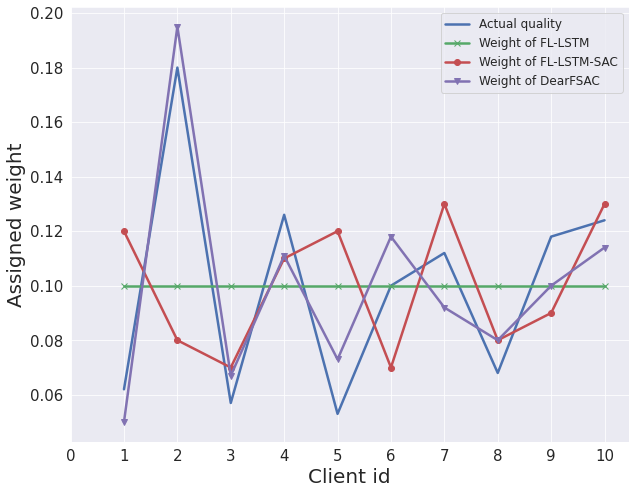

In [67]:
x = list(range(1,11))

quality = [0.053, 0.057, 0.062, 0.068, 0.1, 0.118, 0.112, 0.124, 0.126, 0.18]
random.shuffle(quality)
w_avg = [0.1]*10

w_sac = []
tmp = [0.01,0.02,0.03,0.02,0.03,-0.01,-0.02,-0.03,-0.02,-0.03]
random.shuffle(tmp)
for i in range(len(quality)):
    w_sac.append(w_avg[i]+tmp[i])


w_qeen = []
tmp = [0.01,0.015,0.018,0.02,0.012,-0.01,-0.02,-0.012,-0.015,-0.018]
random.shuffle(tmp)
for i in range(len(quality)):
    w_qeen.append(quality[i]+tmp[i])


fig = plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
ax1 = fig.add_subplot(111)
ax1.plot(x, quality, '-',linewidth=2.5)
ax1.plot(x, w_avg, '-x',linewidth=2.5)
ax1.plot(x, w_sac, '-o',linewidth=2.5)
ax1.plot(x, w_qeen, '-v',linewidth=2.5)
ax1.set_ylabel('Assigned weight', fontsize=20)
ax1.legend(['Actual quality', 'Weight of FL-LSTM', 'Weight of FL-LSTM-SAC', 'Weight of DearFSAC'], prop = {'size':12})
ax1.set_xlabel('Client id', fontsize=20)
plt.xticks(np.arange(0, 11, 1))
plt.tick_params(labelsize=15)

# plt.tick_params(labelsize=15)
plt.savefig('figure/weight.pdf',bbox_inches = 'tight')
plt.show()

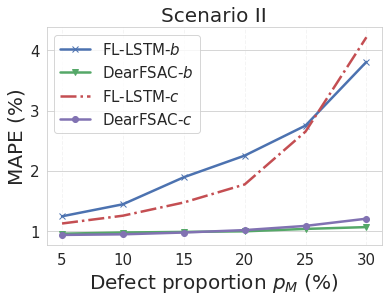

In [39]:
#mape

x = [5, 10, 15, 20, 25, 30]

mape_dear_b = [0.95, 0.97, 0.98, 0.99, 1.03, 1.06]
mape_dear_c = [0.93, 0.94, 0.97, 1.01, 1.08, 1.2]

mape_avg_b = [1.24, 1.44, 1.89, 2.25, 2.75, 3.81]
mape_avg_c = [1.12, 1.25, 1.47, 1.77, 2.65, 4.22]

fig = plt.figure()
sns.set_style("whitegrid")
ax1 = fig.add_subplot(111)
ax1.plot(x, mape_avg_b, '-x',linewidth=2.5)
ax1.plot(x, mape_dear_b, '-v',linewidth=2.5)
ax1.plot(x, mape_avg_c, '-.',linewidth=2.5)
ax1.plot(x, mape_dear_c, '-o',linewidth=2.5)
ax1.set_ylabel('MAPE (%)', {'size':20, 'weight': 'bold'})
ax1.legend(['FL-LSTM-$b$','DearFSAC-$b$','FL-LSTM-$c$','DearFSAC-$c$'], prop={'size':15, 'weight': 'bold'})
ax1.set_xlabel('Defect proportion $p_M$ (%)', {'size':20, 'weight': 'bold'})
plt.tick_params(labelsize=15)
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
# ax1.set_title("Double Y axis")

# ax2 = ax1.twinx()  # this is the important function
# ax2.plot(x, rmse_avg_c, '-o')
# ax2.plot(x, rmse_dear_c, '-o')
# # ax2.set_xlim([0, np.e])
# # ax2.set_ylabel('RMSE (kW)', fontsize=20)
# # ax2.set_xlabel('Defect ratio M (%)', fontsize=20)
# ax2.legend(['rmse_avg_c','rmse_dear_c'], loc=1, prop = {'size':12})
# plt.tick_params(labelsize=15)
plt.savefig('figure/MAPE_bc.pdf',bbox_inches = 'tight')
plt.show()



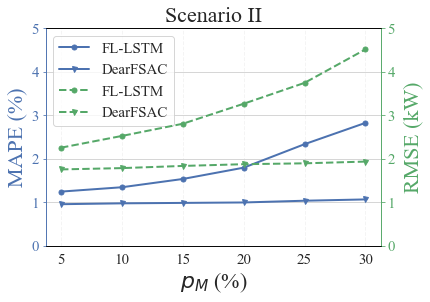

In [110]:
x = [5, 10, 15, 20, 25, 30]

mape_dear_b = [0.95, 0.97, 0.98, 0.99, 1.03, 1.06]
mape_avg_b = [1.24, 1.34, 1.53, 1.79, 2.33, 2.82]

rmse_dear_b = [1.75, 1.78, 1.83, 1.87, 1.89, 1.93]
rmse_avg_b = [2.25,2.52, 2.8, 3.26, 3.74, 4.51]
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, colors='#4C72B0')
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
l1 = ax1.plot(x, mape_avg_b, linestyle='-',marker='o', markersize=5,linewidth=2,color='#4C72B0',label='FL-LSTM')
l2 = ax1.plot(x, mape_dear_b, linestyle='-',marker='v', markersize=5,linewidth=2,color='#4C72B0',label='DearFSAC')

ax2 = ax1.twinx()
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, colors='#55A868')
l3 = ax2.plot(x, rmse_avg_b, linestyle='--',marker='o', markersize=5,linewidth=2,color='#55A868',label='FL-LSTM')
l4 = ax2.plot(x, rmse_dear_b, linestyle='--',marker='v', markersize=5,linewidth=2,color='#55A868',label='DearFSAC')

ls = l1+l2+l3+l4
lab = [l.get_label() for l in ls]
ax1.legend(ls, lab, prop={'size':15})


ax1.set_ylim(0,5)
ax2.set_ylim(0,5)

y_major_locator = MultipleLocator(1)
ax1.yaxis.set_major_locator(y_major_locator)
ax2.yaxis.set_major_locator(y_major_locator)

ax1.set_ylabel('MAPE (%)',{'size':22, 'color':'#4C72B0'})
ax2.set_ylabel('RMSE (kW)',{'size':22, 'color':'#55A868'},labelpad=8.5)
ax1.spines['top'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('#4C72B0')
ax1.spines['right'].set_color('#55A868')
ax2.spines['top'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('#4C72B0')
ax2.spines['right'].set_color('#55A868')

ax1.set_xlabel('$p_M$ (%)', {'size':22})

# plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
# plt.grid()

ax2.grid()

# ax.set_xticks([])
# ax2.set_yticks([])

# [label.set_fontname('Times New Roman') for label in labels]

plt.title('Scenario II',{'size':22})
plt.savefig('figure/MAPE_RMSE_b.pdf',bbox_inches = 'tight')
plt.show()

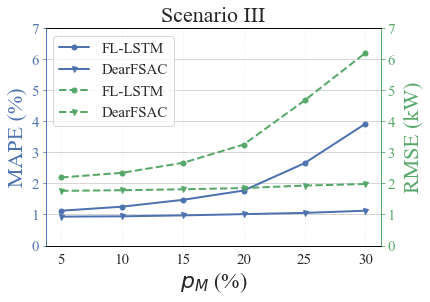

In [109]:
#c

x = [5, 10, 15, 20, 25, 30]


mape_dear_c = [0.93, 0.94, 0.97, 1.01, 1.05, 1.12]
mape_avg_c = [1.12, 1.25, 1.47, 1.77, 2.65, 3.92]

rmse_dear_c = [1.76, 1.78, 1.81, 1.85, 1.93, 1.98]
rmse_avg_c = [2.19, 2.34, 2.66, 3.25, 4.67, 6.2]
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, colors='#4C72B0')
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")

l1 = ax1.plot(x, mape_avg_c,marker='o', markersize=5, linewidth=2, color='#4C72B0', label='FL-LSTM')
l2 = ax1.plot(x, mape_dear_c, '-v',linewidth=2, markersize=5, color='#4C72B0', label='DearFSAC')

ax2 = ax1.twinx()
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15, colors='#55A868')
l3 = ax2.plot(x, rmse_avg_c, linestyle='--',marker='o', markersize=5, linewidth=2,color='#55A868',label='FL-LSTM')
l4 = ax2.plot(x, rmse_dear_c, linestyle='--',marker='v', markersize=5,linewidth=2,color='#55A868',label='DearFSAC')

ls = l1+l2+l3+l4
lab = [l.get_label() for l in ls]
ax1.legend(ls, lab, prop={'size':15}, loc=2)


ax1.set_ylim(0,7)
ax2.set_ylim(0,7)

y_major_locator = MultipleLocator(1)
ax1.yaxis.set_major_locator(y_major_locator)
ax2.yaxis.set_major_locator(y_major_locator)

ax1.set_ylabel('MAPE (%)',{'size':22, 'color':'#4C72B0'})
ax2.set_ylabel('RMSE (kW)',{'size':22, 'color':'#55A868'},labelpad=8.5)
ax1.spines['top'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('#4C72B0')
ax1.spines['right'].set_color('#55A868')
ax2.spines['top'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('#4C72B0')
ax2.spines['right'].set_color('#55A868')

ax1.set_xlabel('$p_M$ (%)', {'size':22})

# plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
# plt.grid()

ax2.grid()

# ax.set_xticks([])
# ax2.set_yticks([])

# [label.set_fontname('Times New Roman') for label in labels]

plt.title('Scenario III',{'size':22})
plt.savefig('figure/MAPE_RMSE_c.pdf',bbox_inches = 'tight')
plt.show()

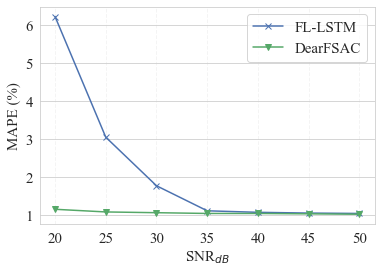

In [15]:
# under scenario c

x = [50, 45, 40, 35, 30, 25, 20]

mape_dear = [1.02, 1.03, 1.04, 1.04, 1.06, 1.08, 1.15]
# rmse_dear = [3,4,3,4,1.85,4,4]

mape_avg = [1.04,1.05,1.07,1.11,1.77, 3.05,6.23]
# rmse_avg = [6,5,5,4,3.15,3,3]
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, mape_avg, '-x',linewidth=1.5)
ax1.plot(x, mape_dear, '-v',linewidth=1.5)
ax1.set_ylabel('MAPE (%)', {'size':15})
ax1.legend(['FL-LSTM','DearFSAC'], prop = {'size':15})
ax1.set_xlabel('SNR$_{dB}$', {'size':15})
plt.tick_params(labelsize=15)
# ax1.set_title("Double Y axis")

# ax2 = ax1.twinx()  # this is the important function
# ax2.plot(x, rmse_dear, '-o')
# ax2.plot(x, rmse_avg, '-o')
# # ax2.set_xlim([0, np.e])
# ax2.set_ylabel('RMSE (kW)', fontsize=20)
# # ax2.set_xlabel('Defect ratio M (%)', fontsize=20)
# ax2.legend(['rmse_avg','rmse_dear'], loc=1, prop = {'size':12})
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.tick_params(labelsize=15)
plt.savefig('figure/SNR_DB.pdf',bbox_inches = 'tight')
plt.show()

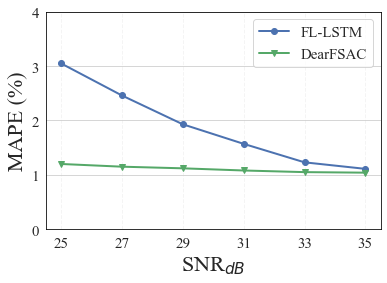

In [107]:
# under scenario c

x = [35, 33, 31, 29, 27, 25]

mape_dear = [1.04, 1.05, 1.08, 1.12, 1.15, 1.2]
# rmse_dear = [3,4,3,4,1.85,4,4]

mape_avg = [1.11, 1.23, 1.57, 1.93, 2.46, 3.05]
# rmse_avg = [6,5,5,4,3.15,3,3]
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, mape_avg, '-o',linewidth=2)
ax1.plot(x, mape_dear, '-v',linewidth=2)
ax1.set_ylabel('MAPE (%)', {'size':22})
ax1.legend(['FL-LSTM','DearFSAC'], prop = {'size':15})
ax1.set_xlabel('SNR$_{dB}$', {'size':22})
ax1.spines['top'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.tick_params(labelsize=15)
ax1.set_xticks(x)
# ax1.set_title("Double Y axis")

# ax2 = ax1.twinx()  # this is the important function
# ax2.plot(x, rmse_dear, '-o')
# ax2.plot(x, rmse_avg, '-o')
# # ax2.set_xlim([0, np.e])
# ax2.set_ylabel('RMSE (kW)', fontsize=20)
# # ax2.set_xlabel('Defect ratio M (%)', fontsize=20)
# ax2.legend(['rmse_avg','rmse_dear'], loc=1, prop = {'size':12})
plt.ylim([0,4]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.tick_params(labelsize=15)
plt.savefig('figure/SNR_DB.pdf',bbox_inches = 'tight')
plt.show()

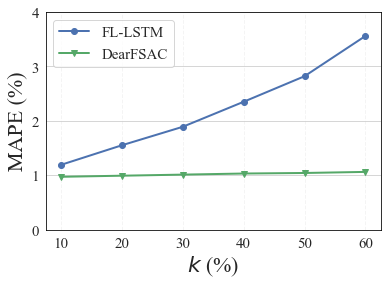

In [108]:
# x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# x = [5, 10, 15, 20, 25, 30, 35, 40]
x = [10, 20, 30, 40, 50, 60]

# mape_dear = [0.87, 0.93, 0.95, 0.97, 0.98, 0.99, 1.01, 1.04, 1.06, 1.07]
# mape_dear = [0.95, 0.97, 0.98, 0.99, 0.99, 1.0, 1.01, 1.04]
mape_dear = [0.97, 0.99, 1.01, 1.03, 1.04, 1.06]
# rmse_dear = [3,4,3,4,3,4]

# mape_avg = [1.1, 1.19, 1.34, 1.55, 1.78, 1.99, 2.15, 2.35, 2.62, 2.83]
# mape_avg = [1.1, 1.19, 1.34, 1.55, 1.78, 1.99, 2.15, 2.35]
mape_avg = [1.19, 1.55, 1.89, 2.35, 2.82, 3.56]
# rmse_avg = [3,4,4,5,5,6]
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(x, mape_avg, '-o',linewidth=2)
ax1.plot(x, mape_dear, '-v',linewidth=2)
ax1.set_ylabel('MAPE (%)', {'size':22})
ax1.legend(['FL-LSTM','DearFSAC'], prop = {'size':15})
ax1.set_xlabel('$k$ (%)', {'size':22})
ax1.spines['top'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.tick_params(labelsize=15)
ax1.set_xticks(x)
# ax1.set_title("Double Y axis")

# ax2 = ax1.twinx()  # this is the important function
# ax2.plot(x, rmse_dear, '-o')
# ax2.plot(x, rmse_avg, '-o')
# # ax2.set_xlim([0, np.e])
# ax2.set_ylabel('RMSE (kW)', fontsize=20)
# # ax2.set_xlabel('Defect ratio M (%)', fontsize=20)
# ax2.legend(['rmse_avg','rmse_dear'], loc=1, prop = {'size':12})
plt.ylim([0,4]) 
plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.tick_params(labelsize=15)
plt.savefig('figure/DIA_ratio.pdf',bbox_inches = 'tight')
plt.show()

In [110]:
from mpl_toolkits.mplot3d import axes3d

class MyAxes3D(axes3d.Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.w_zaxis.get_ticklines() + self.w_zaxis.get_ticklabels():
            t.set_visible(visible)
        self.w_zaxis.line.set_visible(visible)
        self.w_zaxis.pane.set_visible(visible)
        self.w_zaxis.label.set_visible(visible)

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(False)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        zaxis.axes._draw_grid = draw_grid_old

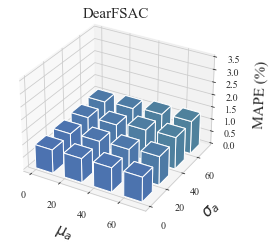

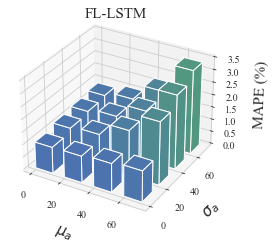

In [116]:
# DIA mu and sigma

bg_color = matplotlib.colors.LinearSegmentedColormap.from_list('bg', 
                                             [(0,    '#4C72B0'),
                                              (1,    '#55A868')], N=256)

# 绘图设置
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.gca(projection='3d')  # 三维坐标轴
# ax = fig.add_axes(MyAxes3D(ax, 'l'))
# X和Y的个数要相同
X = [0, 20, 40, 60]
Y = [0, 20, 40, 60]
Z = [0.95, 0.97, 0.98, 0.99, 
     0.98, 1.03, 1.07, 1.15, 
     1.04, 1.09, 1.23, 1.28, 
     1.11, 1.17, 1.27, 1.32] # 生成16个随机整数
# meshgrid把X和Y变成平方长度，比如原来都是4，经过meshgrid和ravel之后，长度都变成了16，因为网格点是16个
xx, yy = np.meshgrid(X, Y)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()  # 矩阵扁平化
# 设置柱子属性
height = np.zeros_like(Z) # 新建全0数组，shape和Z相同，据说是图中底部的位置
width = 12 # 柱子的长和宽
depth = 12
# 颜色数组，长度和Z一致
# c = ['b']*4 + ['g']*4 + ['y']*4 + ['r']*4

# cmap = cm.get_cmap('hsv') # Get desired colormap - you can change this!
cmap = bg_color
max_height = np.max(Z)   # get range of colorbars so we can normalize
min_height = np.min(Z)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Z] 

# 开始画图，注意本来的顺序是X, Y, Z, width, depth, height，但是那样会导致不能形成柱子，只有柱子顶端薄片，所以Z和height要互换
ax.bar3d(X, Y, height, width, depth, Z,  color=rgba, shade=False)  # width, depth, height
ax.set_xlabel('$\mu_a$',{'size':15},labelpad=8.5)
ax.set_ylabel('$\sigma_a$',{'size':15},labelpad=8.5)
# ax.zaxis.set_rotate_label(False)
ax.set_title('DearFSAC', {'size':15},pad=-10)
ax.set_zlabel('MAPE (%)',{'size':15},labelpad=8.5)
ax.set_zlim3d(0,3.5)
# ax.set_xticks(X)
# ax.set_yticks(Y)


plt.savefig('figure/DIA_dear.pdf',bbox_inches = 'tight')
plt.show()


sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.gca(projection='3d')  # 三维坐标轴
# X和Y的个数要相同
X = [0, 20, 40, 60]
Y = [0, 20, 40, 60]
Z = [1.05, 1.07, 1.15, 1.24, 
     1.21, 1.31, 1.82, 2.51, 
     1.30, 1.44, 1.99, 2.95, 
     1.38, 1.56, 2.21, 3.34] # 生成16个随机整数
# meshgrid把X和Y变成平方长度，比如原来都是4，经过meshgrid和ravel之后，长度都变成了16，因为网格点是16个
xx, yy = np.meshgrid(X, Y)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()  # 矩阵扁平化
# 设置柱子属性
height = np.zeros_like(Z) # 新建全0数组，shape和Z相同，据说是图中底部的位置
width = 12 # 柱子的长和宽
depth = 12
# 颜色数组，长度和Z一致
# c = ['b']*4 + ['g']*4 + ['y']*4 + ['r']*4

# cmap = cm.get_cmap('turbo') # Get desired colormap - you can change this!
cmap = bg_color
max_height = np.max(Z)   # get range of colorbars so we can normalize
min_height = np.min(Z)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Z] 

# 开始画图，注意本来的顺序是X, Y, Z, width, depth, height，但是那样会导致不能形成柱子，只有柱子顶端薄片，所以Z和height要互换
ax.bar3d(X, Y, height, width, depth, Z,  color=rgba, shade=False)  # width, depth, height
ax.set_xlabel('$\mu_a$',{'size':15},labelpad=8.5)
ax.set_ylabel('$\sigma_a$',{'size':15},labelpad=8.5)
# ax.zaxis.set_rotate_label(False)
ax.set_title('FL-LSTM', {'size':15},pad=-10)
ax.set_zlabel('MAPE (%)',{'size':15},labelpad=8.5)
plt.savefig('figure/DIA_avg.pdf',bbox_inches = 'tight')
ax.set_zlim3d(0,3.5)
# ax.set_xticks(X)
# ax.set_yticks(Y)
# plt.grid(linestyle='--',linewidth=1,alpha=0.2,axis="x")
plt.show()

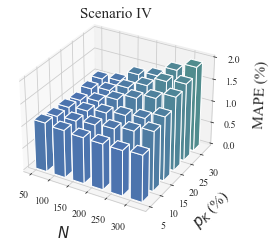

In [115]:
#scalability d
bg_color = matplotlib.colors.LinearSegmentedColormap.from_list('bg', 
                                             [(0,    '#4C72B0'),
                                              (1,    '#55A868')], N=256)
# 绘图设置
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.gca(projection='3d')  # 三维坐标轴
# X和Y的个数要相同
X = [50, 100, 150, 200, 250, 300]
Y = [5, 10, 15, 20, 25, 30]
Z = [1.12, 1.08, 1.05, 1.04, 1.03, 1.06,
     1.05, 1.07, 1.11, 1.15, 1.23, 1.35,
     1.04, 1.08, 1.16, 1.23, 1.29, 1.45,
     0.99, 1.09, 1.25, 1.40, 1.52, 1.67,
     1.05, 1.13, 1.31, 1.48, 1.69, 1.75,
     1.08, 1.15, 1.41, 1.50, 1.74, 1.92] # 生成16个随机整数
# meshgrid把X和Y变成平方长度，比如原来都是4，经过meshgrid和ravel之后，长度都变成了16，因为网格点是16个
xx, yy = np.meshgrid(X, Y)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()  # 矩阵扁平化
# 设置柱子属性
height = np.zeros_like(Z) # 新建全0数组，shape和Z相同，据说是图中底部的位置
width = 30 # 柱子的长和宽
depth = 3
# 颜色数组，长度和Z一致

# cmap = cm.get_cmap('brg') # Get desired colormap - you can change this!
cmap = bg_color
max_height = np.max(Z)   # get range of colorbars so we can normalize
min_height = np.min(Z)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Z] 

# c = ['b']*6 + ['g']*6 + ['y']*6 + ['orange']*6 +['r']*6+['purple']*6

# 开始画图，注意本来的顺序是X, Y, Z, width, depth, height，但是那样会导致不能形成柱子，只有柱子顶端薄片，所以Z和height要互换
ax.bar3d(X, Y, height, width, depth, Z, color=rgba, shade=False)  # width, depth, height
ax.set_xlabel('$N$',{'size':15},labelpad=8.5)
ax.set_ylabel('$p_K$ (%)',{'size':15},labelpad=8.5)
# ax.zaxis.set_rotate_label(False)
ax.set_title('Scenario IV', {'size':15},pad=-10)
ax.set_zlabel('MAPE (%)',{'size':15},labelpad=8.5)
# ax.set_xticks(X)
# ax.set_yticks(Y)
ax.set_zlim3d(0,2)
plt.savefig('figure/scala_NK_d.pdf',bbox_inches = 'tight')
plt.show()

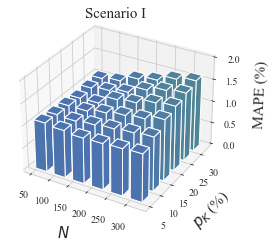

In [117]:
#scalability a

bg_color = matplotlib.colors.LinearSegmentedColormap.from_list('bg', 
                                             [(0,    '#4C72B0'),
                                              (1,    '#55A868')], N=256)

# 绘图设置
sns.set_style("whitegrid")
plt.rc('font',family='Times New Roman')
fig = plt.figure()
ax = fig.gca(projection='3d')  # 三维坐标轴
# X和Y的个数要相同
X = [50, 100, 150, 200, 250, 300]
Y = [5, 10, 15, 20, 25, 30]
Z = [1.12, 1.08, 1.04, 1.05, 1.07, 1.09,
     1.09, 1.07, 1.11, 1.15, 1.19, 1.23,
     1.08, 1.08, 1.16, 1.23, 1.28, 1.39,
     1.04, 1.05, 1.25, 1.30, 1.42, 1.47,
     1.07, 1.13, 1.21, 1.38, 1.49, 1.55,
     1.09, 1.15, 1.31, 1.40, 1.54, 1.62] # 生成16个随机整数
# meshgrid把X和Y变成平方长度，比如原来都是4，经过meshgrid和ravel之后，长度都变成了16，因为网格点是16个
xx, yy = np.meshgrid(X, Y)  # 网格化坐标
X, Y = xx.ravel(), yy.ravel()  # 矩阵扁平化
# 设置柱子属性
height = np.zeros_like(Z) # 新建全0数组，shape和Z相同，据说是图中底部的位置
width = 30 # 柱子的长和宽
depth = 3
# 颜色数组，长度和Z一致

# cmap = cm.get_cmap('brg') # Get desired colormap - you can change this!
cmap = bg_color
max_height = np.max(Z)   # get range of colorbars so we can normalize
min_height = np.min(Z)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in Z] 

# c = ['b']*6 + ['g']*6 + ['y']*6 + ['orange']*6 +['r']*6+['purple']*6


# 开始画图，注意本来的顺序是X, Y, Z, width, depth, height，但是那样会导致不能形成柱子，只有柱子顶端薄片，所以Z和height要互换
ax.bar3d(X, Y, height, width, depth, Z,  color=rgba, shade=False)  # width, depth, height
ax.set_xlabel('$N$',{'size':15},labelpad=8.5)
ax.set_ylabel('$p_K$ (%)',{'size':15},labelpad=8.5)
# ax.zaxis.set_rotate_label(False)
ax.set_title('Scenario I', {'size':15}, pad=-10)
ax.set_zlabel('MAPE (%)',{'size':15},labelpad=8.5)
# ax.set_xticks(X)
# ax.set_yticks(Y)
# ax.set_zticks([0,0.5,1,1.5,2])
ax.set_zlim3d(0,2)
plt.tick_params(labelsize=10)
plt.savefig('figure/scala_NK_a.pdf',bbox_inches = 'tight')
plt.show()

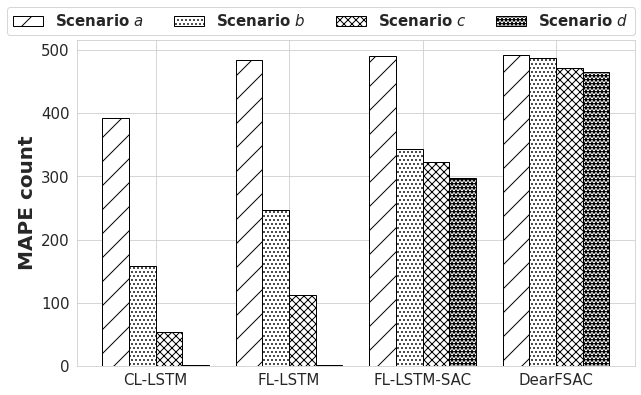

In [52]:
# 低于2.5 mape的次数和第一次 直方图

# mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
sns.set_style("whitegrid")
a1 = [392,485,491,492]
a2 = [158,246,344,488]
a3 = [54,112,323,471]
a4 = [1,1,298,466]

labels = ['CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'] 
bar_width = 0.2
 
# 绘图
plt.figure(figsize=(10,6))
plt.bar(np.arange(4), a1, label='Scenario $a$', color='white', alpha=1, width=bar_width,edgecolor="k",hatch='/') 
plt.bar(np.arange(4) + bar_width, a2, label='Scenario $b$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="...")
plt.bar(np.arange(4) + 2*bar_width, a3, label='Scenario $c$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="xxx")
plt.bar(np.arange(4) + 3*bar_width, a4, label='Scenario $d$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="***")

 
# 添加刻度标签 
plt.ylabel('MAPE count',{'size':20, 'weight': 'bold'})
plt.xticks(np.arange(4) + 1.5*bar_width, labels)
plt.tick_params(labelsize=15)
# plt.title('MAPE count', fontsize=20)
# 设置Y轴的刻度范围 
# plt.ylim([0, 100]) 
 
# # 为每个条形图添加数值标签 
# for x2016, y2016 in enumerate(Y2016): 
#     plt.text(x2016, y2016 + 2, '%s' % y2016, ha='center',fontsize=20) 
 
# for x2017, y2017 in enumerate(Y2017): 
#     plt.text(x2017 + bar_width, y2017 + 2, '%s' % y2017, ha='center',fontsize=20)

# for x2018, y2018 in enumerate(Y2018): 
#     plt.text(x2018 + 2*bar_width, y2018 + 2, '%s' % y2018, ha='center',fontsize=20)

# 显示图例
plt.legend(bbox_to_anchor=(1,1.1), borderaxespad=0, ncol=4, prop={'size':15, 'weight': 'bold'})

# 显示图形 
plt.savefig('figure/MAPE count.pdf',bbox_inches = 'tight')
plt.show() 

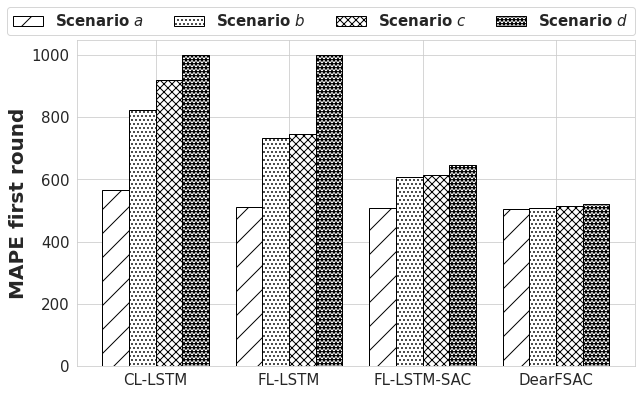

In [51]:
#MAPE first round

# mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
sns.set_style("whitegrid")
a1 = [565,512,507,505]
a2 = [822,733,608,509]
a3 = [921,745,615,515]
a4 = [1000,1000,645, 520]

labels = ['CL-LSTM', 'FL-LSTM', 'FL-LSTM-SAC', 'DearFSAC'] 
bar_width = 0.2
 
# 绘图
plt.figure(figsize=(10,6))
plt.bar(np.arange(4), a1, label='Scenario $a$', color='white', alpha=1, width=bar_width,edgecolor="k",hatch='/') 
plt.bar(np.arange(4) + bar_width, a2, label='Scenario $b$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="...")
plt.bar(np.arange(4) + 2*bar_width, a3, label='Scenario $c$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="xxx")
plt.bar(np.arange(4) + 3*bar_width, a4, label='Scenario $d$', color='white', alpha=1, edgecolor="k",width=bar_width,hatch="***")

 
# 添加刻度标签 
plt.ylabel('MAPE first round',{'size':20, 'weight': 'bold'})
plt.xticks(np.arange(4) + 1.5*bar_width, labels)
plt.tick_params(labelsize=15)
# plt.title('MAPE count', fontsize=20)
# 设置Y轴的刻度范围 
# plt.ylim([0, 100]) 
 
# # 为每个条形图添加数值标签 
# for x2016, y2016 in enumerate(Y2016): 
#     plt.text(x2016, y2016 + 2, '%s' % y2016, ha='center',fontsize=20) 
 
# for x2017, y2017 in enumerate(Y2017): 
#     plt.text(x2017 + bar_width, y2017 + 2, '%s' % y2017, ha='center',fontsize=20)

# for x2018, y2018 in enumerate(Y2018): 
#     plt.text(x2018 + 2*bar_width, y2018 + 2, '%s' % y2018, ha='center',fontsize=20)

# 显示图例
plt.legend(bbox_to_anchor=(1,1.1), borderaxespad=0, ncol=4, prop={'size':15, 'weight': 'bold'})

# 显示图形 
plt.savefig('figure/MAPE first round.pdf',bbox_inches = 'tight')
plt.show() 